<a href="https://colab.research.google.com/github/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/blob/main/Energy_Carrier_Wise_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.3983 - val_loss: 0.2526
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step - loss: 0.3614 - val_loss: 0.2243
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2997 - val_loss: 0.1970
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2475 - val_loss: 0.1717
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1935 - val_loss: 0.1483
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1397 - val_loss: 0.1301
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.1076 - val_loss: 0.1210
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0727 - val_loss: 0.1252
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0675 - val_loss: 0.1419
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0838 - val_loss: 0.1548
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1125 - val_loss: 0.1521
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0997 

<ipython-input-3-1090e49267cd>:97: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start='2021', periods=n_future_steps, freq='Y').year


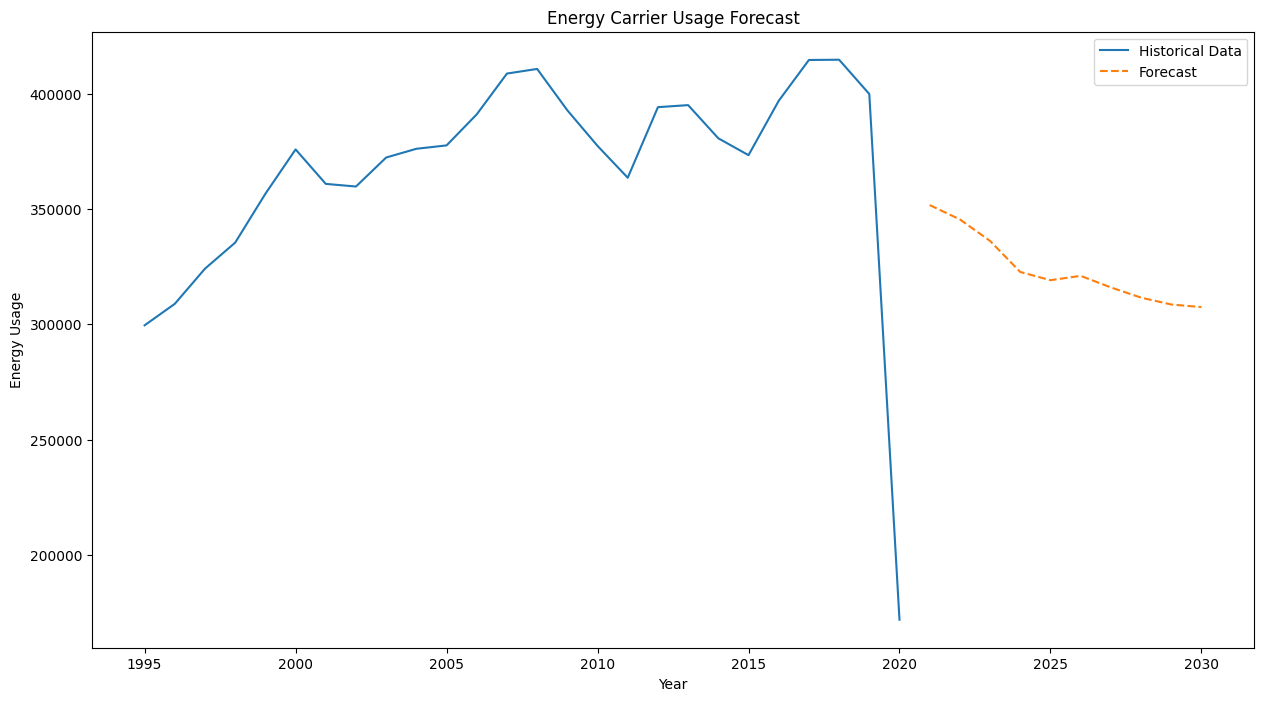


Forecasted values for 2021-2030:
Energy Carriers  Aviation turbine fuel  \
2021                     351710.879032   
2022                     345504.659502   
2023                     336169.644705   
2024                     322705.142554   
2025                     319132.758383   
2026                     321019.441012   
2027                     315997.114614   
2028                     311575.733396   
2029                     308594.955538   
2030                     307466.096561   

Energy Carriers  Brown coal (lignite) and brown coal products     Crude oil  \
2021                                             1.549944e+06  3.837428e+06   
2022                                             1.535741e+06  3.820524e+06   
2023                                             1.509421e+06  3.797895e+06   
2024                                             1.477394e+06  3.795184e+06   
2025                                             1.470887e+06  3.812376e+06   
2026                         

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Data preprocessing
def load_and_preprocess_data(file_path):
    # Read data
    df = pd.read_csv(file_path)

    # Melt the year columns into a single column
    df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                        var_name='Year', value_name='Energy_Usage')

    # Convert Year to numeric
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])

    # Pivot to get energy carriers as columns
    df_pivot = df_melted.pivot_table(index='Year',
                                   columns='Energy Carriers',
                                   values='Energy_Usage',
                                   aggfunc='sum')

    return df_pivot

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :])
    return np.array(X), np.array(y)

# Model building
def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(output_shape)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# Forecasting function
def forecast_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next step
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(next_pred[0])

        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred[0]

    return scaler.inverse_transform(future_predictions)

# Main execution
def main():
    # Load and preprocess data
    file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
    data = load_and_preprocess_data(file_path)

    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    seq_length = 5
    X, y = create_sequences(scaled_data, seq_length)

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train model
    model = build_lstm_model((seq_length, X.shape[2]), y.shape[1])
    history = model.fit(X_train, y_train,
                       epochs=100,
                       batch_size=32,
                       validation_data=(X_test, y_test),
                       verbose=1)

    # Make future predictions (2021-2030)
    n_future_steps = 10
    future_pred = forecast_future(model, X[-1], n_future_steps, scaler)

    # Create future dates
    future_years = pd.date_range(start='2021', periods=n_future_steps, freq='Y').year

    # Plot results
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data.iloc[:, 0], label='Historical Data')
    plt.plot(future_years, future_pred[:, 0], label='Forecast', linestyle='--')
    plt.title('Energy Carrier Usage Forecast')
    plt.xlabel('Year')
    plt.ylabel('Energy Usage')
    plt.legend()
    plt.show()

    # Print forecasted values
    forecast_df = pd.DataFrame(future_pred,
                             index=future_years,
                             columns=data.columns)
    print("\nForecasted values for 2021-2030:")
    print(forecast_df)

if __name__ == "__main__":
    main()

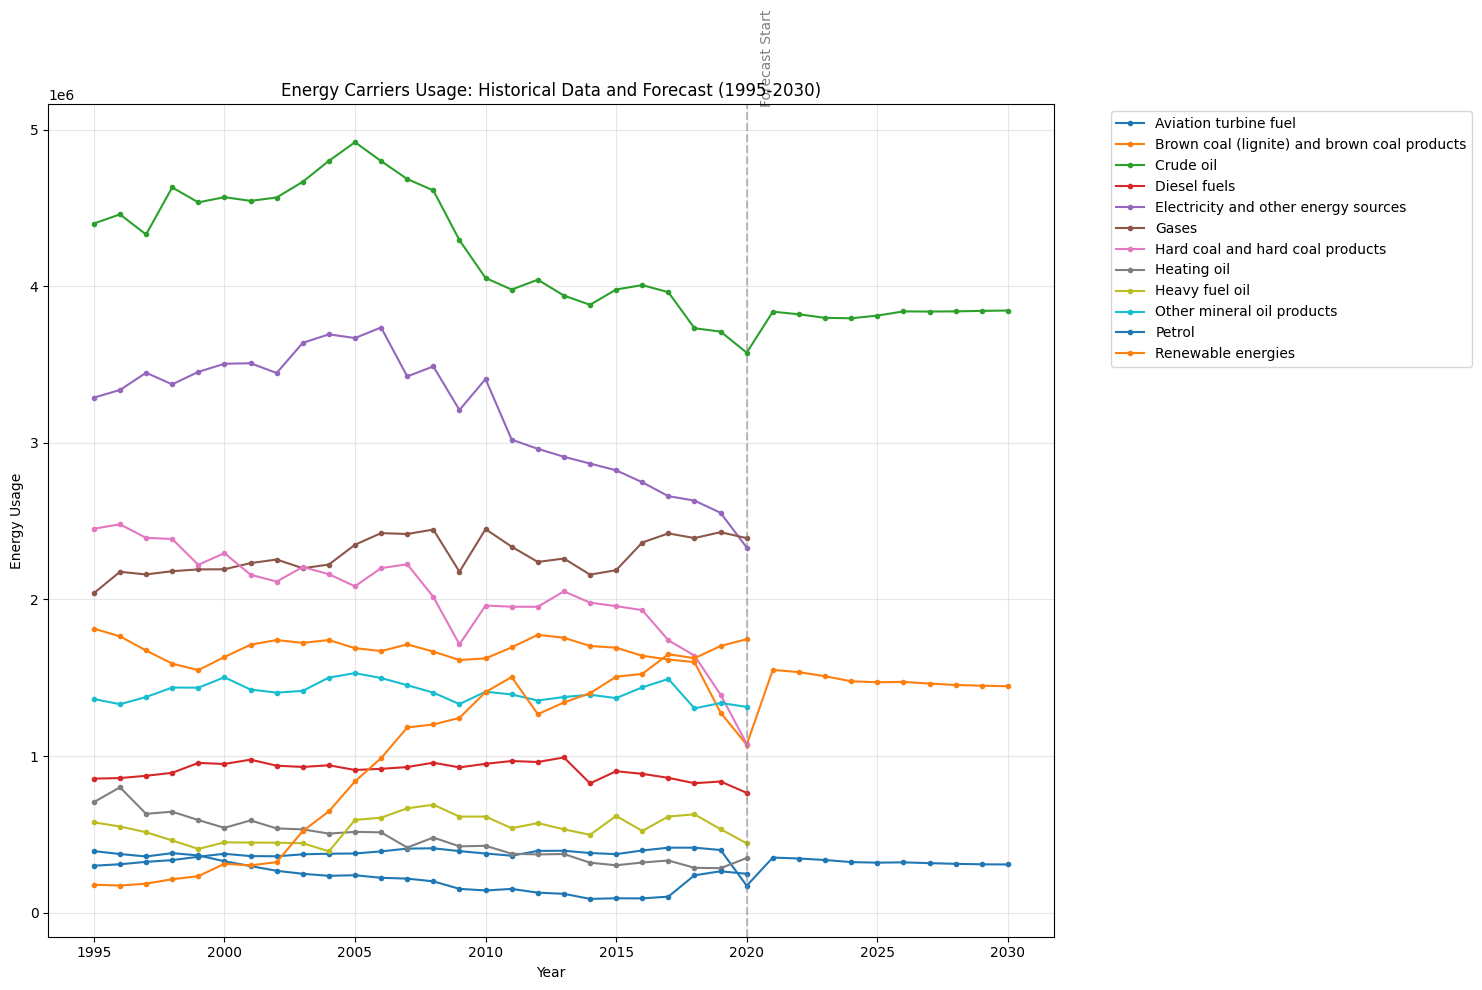

Data exported to energy_carriers_forecast.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess historical data
def prepare_data(file_path):
    df = pd.read_csv(file_path)
    df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                       var_name='Year', value_name='Energy_Usage')
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])
    return df_melted

# Combine historical and forecast data
def combine_data(historical_data, forecast_data):
    historical_pivot = historical_data.pivot_table(index='Year',
                                                 columns='Energy Carriers',
                                                 values='Energy_Usage',
                                                 aggfunc='sum')

    combined_data = pd.concat([historical_pivot, forecast_data])
    return combined_data

# Create visualization
def plot_energy_carriers(combined_data):
    plt.figure(figsize=(15, 10))

    # Plot each energy carrier
    for carrier in combined_data.columns:
        plt.plot(combined_data.index, combined_data[carrier], label=carrier, marker='o', markersize=3)

    # Add vertical line to separate historical and forecast data
    plt.axvline(x=2020, color='gray', linestyle='--', alpha=0.5)
    plt.text(2020.5, plt.ylim()[1], 'Forecast Start', rotation=90, alpha=0.5)

    plt.title('Energy Carriers Usage: Historical Data and Forecast (1995-2030)')
    plt.xlabel('Year')
    plt.ylabel('Energy Usage')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Export combined data to Excel
def export_to_excel(combined_data, filename='energy_carriers_forecast.xlsx'):
    combined_data.to_excel(filename)
    print(f"Data exported to {filename}")

# Execute
file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
historical_data = prepare_data(file_path)
forecast_data = pd.DataFrame({
    'Aviation turbine fuel': [351710.879032, 345504.659502, 336169.644705, 322705.142554,
                            319132.758383, 321019.441012, 315997.114614, 311575.733396,
                            308594.955538, 307466.096561],
    'Brown coal (lignite) and brown coal products': [1.549944e6, 1.535741e6, 1.509421e6,
                                                    1.477394e6, 1.470887e6, 1.473421e6,
                                                    1.462572e6, 1.453818e6, 1.448968e6, 1.445741e6],
    'Crude oil': [3.837428e6, 3.820524e6, 3.797895e6, 3.795184e6, 3.812376e6,
                  3.839120e6, 3.838164e6, 3.839432e6, 3.842425e6, 3.844741e6]
    # Add other energy carriers as needed
}, index=range(2021, 2031))

combined_data = combine_data(historical_data, forecast_data)
plot_energy_carriers(combined_data)
export_to_excel(combined_data)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                       var_name='Year', value_name='Energy_Usage')
    df_melted['Year'] = pd.to_numeric(df_melted['Year'])
    df_pivot = df_melted.pivot_table(index='Year',
                                   columns='Energy Carriers',
                                   values='Energy_Usage',
                                   aggfunc='sum')
    return df_pivot

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, :])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, output_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def forecast_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        future_predictions.append(next_pred[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred[0]

    return scaler.inverse_transform(future_predictions)

# Main execution
file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
data = load_and_preprocess_data(file_path)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
seq_length = 5
X, y = create_sequences(scaled_data, seq_length)

# Train model
model = build_lstm_model((seq_length, X.shape[2]), y.shape[1])
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Generate forecasts
n_future_steps = 10
future_pred = forecast_future(model, X[-1], n_future_steps, scaler)

# Create forecast DataFrame
future_years = range(2021, 2031)
forecast_df = pd.DataFrame(future_pred,
                         index=future_years,
                         columns=data.columns)

# Export to Excel
forecast_df.to_excel('all_energy_carriers_forecast_2021_2030.xlsx')
print("All energy carriers forecast data has been exported to 'all_energy_carriers_forecast_2021_2030.xlsx'")

# Display first few rows of the forecast
print("\nFirst few rows of the forecast data:")
print(forecast_df.head())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
All energy carriers forecast data has been exported to 'all_energy_carriers_forecast_2021_2030.xlsx'

First few rows of the forecast data:
Energy Carriers  Aviation turbine fuel  \
2021                     296657.263894   
2022                     278565.867552   
2023                     262537.108214   
2024                     254606.600974   
2025                     250610.101970   

Energy Carriers  Brown coal (lignite) and brown coal products     Crude oil  \
2021                                             1.381807e+06  3.715956e+06   
2022                                             1.348400e+06  3.6674